In [138]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [139]:
df = pd.read_excel('/Users/Пользователь/Downloads/прирост по дням.xlsx')


In [140]:
df.head()

,Дата,Заражений за день,Выздоровлений за день,Смертей за день
0,2020-03-12,34,0,0
1,2020-03-13,11,0,0
2,2020-03-14,14,0,0
3,2020-03-15,4,3,0
4,2020-03-16,28,2,0


In [141]:
df['Дата'] = pd.to_datetime(df['Дата'])

In [142]:
df['Заражений за день']

0         34
1         11
2         14
3          4
4         28
        ... 
1033    2754
1034    3032
1035    4201
1036    4675
1037    5078
Name: Заражений за день, Length: 1038, dtype: int64

In [143]:
df.columns

Index(['Дата', 'Заражений за день', 'Выздоровлений за день',
       'Смертей за день'],
      dtype='object')

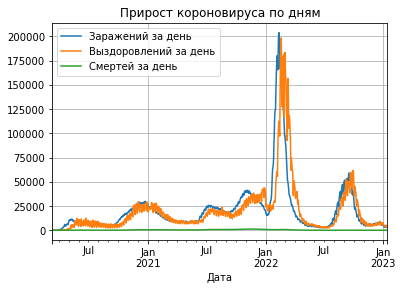

In [144]:
df.plot(x='Дата', y=['Заражений за день', 'Выздоровлений за день', 'Смертей за день'], title = 'Прирост короновируса по дням')
plt.grid()

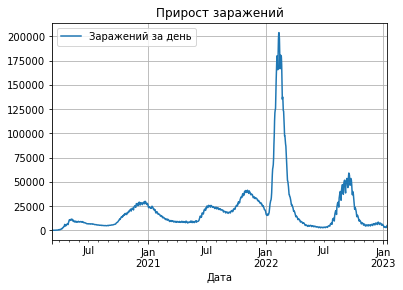

In [145]:
df.plot(x='Дата', y='Заражений за день', title = 'Прирост заражений')
plt.grid()

Необходимо найти частоту дискретизации


In [146]:
t_d = np.mean(np.diff(df['Дата'])) / np.timedelta64(1, 's') #np.timedelta64(1, 's') для перевода в секунды
t_d

86400.0

In [147]:
data_sec = []
for i in range(df.shape[0]):
      data_sec.append(i*t_d)
f_d = 1/t_d
print ('Количество диапазонов с частотой дискретизации', round(f_d, 8) , 'сек -', len(data_sec))

Количество диапазонов с частотой дискретизации 1.157e-05 сек - 1038


In [148]:
df['seconds'] = data_sec

Необходимо применить прямое преобразование Фурье для того, чтобы получить спектр

In [149]:
t_new = [i*t_d for i in range (int(max(data_sec)//t_d))]
df_fourier = np.fft.fft(df['Заражений за день'])
fr = [i/t_new[-1] for i in range(len(df['Заражений за день']))]

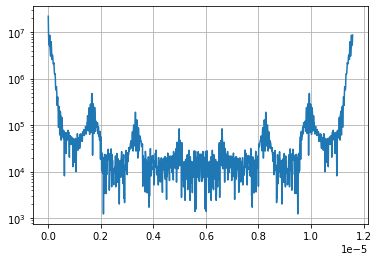

In [150]:
plt.figure()
plt.semilogy(fr, abs(df_fourier))
plt.grid()

Выделим часть спектра: исходя из рисунка выше можно выделить половину, так как спектр симметричен 

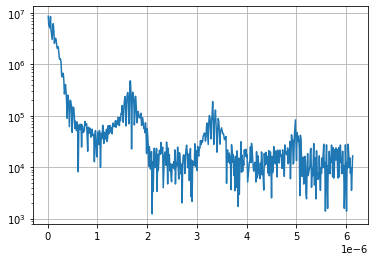

In [151]:
plt.figure()
plt.semilogy(fr[1:550], abs(df_fourier)[1:550])
plt.grid()

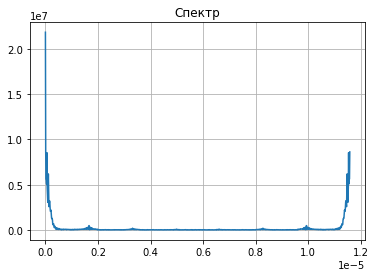

In [152]:
from scipy.signal import find_peaks
peaks = find_peaks(fr)
plt.figure()
plt.plot(fr, abs(df_fourier))
plt.title('Спектр')
plt.grid()

In [153]:
df['fourier']=abs(df_fourier)
df

,Дата,Заражений за день,Выздоровлений за день,Смертей за день,seconds,fourier
0,2020-03-12,34,0,0,0.0,2.184672e+07
1,2020-03-13,11,0,0,86400.0,8.621454e+06
2,2020-03-14,14,0,0,172800.0,5.636214e+06
3,2020-03-15,4,3,0,259200.0,5.622244e+06
4,2020-03-16,28,2,0,345600.0,5.082211e+06
...,...,...,...,...,...,...
1033,2023-01-09,2754,2990,41,89251200.0,8.538142e+06
1034,2023-01-10,3032,5062,47,89337600.0,5.082211e+06
1035,2023-01-11,4201,5122,46,89424000.0,5.622244e+06
1036,2023-01-12,4675,4541,48,89510400.0,5.636214e+06


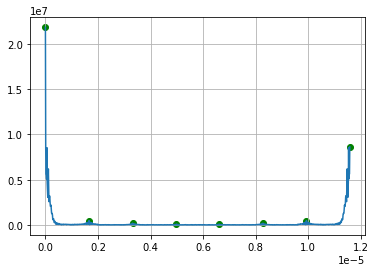

In [154]:
from scipy.signal import argrelextrema
n=50
df['local_max_fourier'] = df.iloc[argrelextrema(df.fourier.values, np.greater_equal, order=n)[0]]['fourier']
plt.plot(fr, abs(df_fourier))
plt.scatter(fr,df['local_max_fourier'] , c='g')
plt.grid()

In [155]:
df['fr']=fr
freq_of_fluc = df[abs(df_fourier)==df['local_max_fourier']].copy()
freq_of_fluc.index = np.arange(len(freq_of_fluc))
freq_of_fluc

,Дата,Заражений за день,Выздоровлений за день,Смертей за день,seconds,fourier,local_max_fourier,fr
0,2020-03-12,34,0,0,0.0,2.184672e+07,2.184672e+07,0.000000
1,2020-08-08,5212,6615,129,12873600.0,4.781567e+05,4.781567e+05,0.000002
2,2021-01-03,24150,19847,504,25660800.0,1.890479e+05,1.890479e+05,0.000003
3,2021-06-01,9500,8994,372,38534400.0,8.316752e+04,8.316752e+04,0.000005
4,2021-10-25,37930,20690,1069,51148800.0,8.316752e+04,8.316752e+04,0.000007
5,2022-03-23,26826,70622,429,64022400.0,1.890479e+05,1.890479e+05,0.000008
6,2022-08-18,35809,21491,62,76809600.0,4.781567e+05,4.781567e+05,0.000010
7,2023-01-13,5078,4271,47,89596800.0,8.621454e+06,8.621454e+06,0.000012


Изходя из таблицы можно наблюдать границы периодов

In [156]:
l = []
for i in range(0,len(freq_of_fluc)-1):
    r = freq_of_fluc.fr[i+1] - freq_of_fluc.fr[i]
    l.append(r)
l = np.array(l)
days = (1/(l*3600*24))
print(np.round(days,2))

[6.95 7.   6.95 7.1  6.95 7.   7.  ]


Периодичность ~ 7 дней

Необходимо найти локальные максимумы в исх. графике

In [157]:
df ['data']=df['Заражений за день']

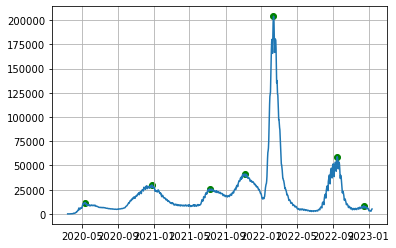

In [158]:
from scipy.signal import argrelextrema
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal, order=n)[0]]['data']
plt.scatter(df['Дата'], df['max'], c='g')
plt.plot(df['Дата'],df['Заражений за день'])
plt.grid()

In [159]:
df['max_NaN'] = np.where(df['max'].isnull(), 0,1)
print('Даты, соответствующие наивысшим точкам каждой волны заболеваемости:', '\n')
df = df[df['max_NaN']!=0]
df['Дата']

Даты, соответствующие наивысшим точкам каждой волны заболеваемости: 



60     2020-05-11
287    2020-12-24
484    2021-07-09
604    2021-11-06
701    2022-02-11
918    2022-09-16
1009   2022-12-16
Name: Дата, dtype: datetime64[ns]

Вывод: в ходе домашней работы была произведена высокочастотная периодичность прироста новых случаев заболевания COVID-19, период  изменения равен приблезительно 7 дней. Данные изменения предположительно связаны с увеличением заболевших после выходных. Также были определены даты, которые соотвествуют наибольшему приросту заболеваемости в течении всего периода. Осень и зима - сезонное послабление иммунитета у людей, соответсвенно в сезонное время происходит увелечение численности заболевания. 